In [5]:
# load data
file_path = "../other_datasets/icfca/preprocessed/"
json_path='../other_datasets/icfca/decoding.json'
csv_path='../other_datasets/icfca/icfca-context.csv'
train_path='../other_datasets/icfca/preprocessed/icfca.train.pkl'
test_path='../other_datasets/icfca/preprocessed/icfca.test.pkl'
full_path='../other_datasets/icfca/preprocessed/icfca.pkl'
authors_path = '../other_datasets/icfca/authors.npy'
articles_path = '../other_datasets/icfca/articles.npy'

In [1]:
import torch
from dataset import *

In [6]:
dataset = LatticeDataset(file_path)
order_train, sequence_train, object_to_concept_train, attribute_to_concept_train, extents_train, intents_train, context_train = load_lattice(train_path)
extents_train = extents_train.transpose()
order_test, sequence_test, object_to_concept_test, attribute_to_concept_test, extents_test, intents_test, context_test = load_lattice(test_path)
extents_test = extents_test.transpose()
order_full, sequence_full, object_to_concept_full, attribute_to_concept_full, extents_full, intents_full, context_full = load_lattice(full_path)
extents_full = extents_full.transpose()
" As attributes we use all publications of these authors. "
((len(object_to_concept_train), len(object_to_concept_test), len(object_to_concept_full)),
 (len(attribute_to_concept_train), len(attribute_to_concept_test), len(attribute_to_concept_full)))

((334, 254, 351), (12613, 12614, 12614))

In [3]:
len(np.load(authors_path, allow_pickle=True))

351

In [16]:
torch.tensor(context_train).any(dim=0).sum()/12614.

tensor(0.8226)

In [23]:
torch.tensor(context_train).float().mean(dim=1).mean() , torch.tensor(context_train).float().mean(dim=1).std()

(tensor(0.0031), tensor(0.0053))

In [126]:
# apply Attribute2vec model on data (same as o2v, with just a transpose of the contxt and using itents instead of extents)
import object2vec as o2v

vocabulary_length = object_to_concept_full.shape[0]
vocabulary = [i for i in range(vocabulary_length)]
batch_length = 32

extents_ = [[i for i, value in enumerate(extent) if value] for extent in extents_full]
data = o2v.to_samples(extents_, "CBoW")

batches_CBoW = []
for batch in (data[i:i+batch_length] for i in range(0, len(data), batch_length)):
    inputs, targets = [], []
    offsets = [0]
    for input, target in batch:
        inputs.append(input)
        targets.append(target)
        offsets.append(offsets[-1] + len(input))
    batches_CBoW.append((torch.cat(inputs), torch.tensor(offsets[:-1]), torch.cat(targets),))

data = o2v.to_samples(extents_, "SG")

batches_SG = []
for batch in (data[i:i+batch_length] for i in range(0, len(data), batch_length)):
    inputs, targets = [], []
    for input, target in batch:
        inputs.append(input)
        targets.append(target)
    batches_SG.append((torch.cat(inputs), torch.cat(targets),))

In [127]:
from torch.optim.lr_scheduler import LambdaLR

epochs = 200
embedding_size = 3 #2 or 3 dimensions (l 9 p 15)
num_iter = 5
lr = 1
lambda_ = lambda epoch: lr - (epoch / epochs)
device = 'cuda'

emb_models_list = []
for iteration in range(num_iter):
    for mode in ["SG", "CBoW"]:
        print(iteration, mode)
        model = o2v.Object2Vec(embedding_size, vocabulary_length, mode).to(device)
        optim = o2v.torch.optim.Adam(model.parameters(), lr = lr)
        criterion = o2v.nn.CrossEntropyLoss()
        scheduler = LambdaLR(optim, lr_lambda=lambda_)
        if mode == "CBoW":
            for epoch in range(epochs):
                losses = []
                for input, offsets, target in batches_CBoW:
                    #if mode == "CBoW": input = input.view(1,-1) # fake batch
                    out = model(input.to(device), offsets.to(device))

                    loss = criterion(out, target.to(device))

                    loss.backward()
                    optim.step()
                    optim.zero_grad()

                    losses.append(loss.cpu().item())
                
                print(epoch, sum(losses)/len(losses))
                scheduler.step()

            with torch.no_grad():
                attributes = torch.arange(vocabulary_length).view(-1, 1)
                o2v_emb = model.embeddings(attributes.to(device)).cpu()
        else:
            for epoch in range(epochs):
                losses = []
                for input, target in batches_SG:
                    out = model(input.to(device))

                    loss = criterion(out, target.to(device))

                    loss.backward()
                    optim.step()
                    optim.zero_grad()

                    losses.append(loss.cpu().item())
                
                print(epoch, sum(losses)/len(losses))
                scheduler.step()

            with torch.no_grad():
                attributes = torch.arange(vocabulary_length)
                o2v_emb = model.embeddings(attributes.to(device)).cpu()

        emb_models_list.append((o2v_emb, 'o2v ' + mode, ))

0 SG
0 61.74401209564538
1 105.97189500036959
2 124.2261451787079
3 124.16299617996003
4 122.8841225224641
5 117.1240240266125
6 122.74031691712294
7 116.78119724100242
8 117.67076203348917
9 119.28904052576439
10 110.23173881600525
11 109.66892780844621
12 118.62303175670652
13 115.62319159053563
14 114.76486503469299
15 111.15500385457864
16 107.13705704349657
17 106.96738046869457
18 99.60513339261885
19 107.76238232322656
20 103.89361929705763
21 95.09711228114625
22 100.40961278063227
23 93.52515209838464
24 91.64212819129222
25 89.70815178050225
26 92.72105561509059
27 87.05608755445492
28 92.72389006669188
29 90.84484524638452
30 89.8773190689959
31 88.01918200354059
32 84.89499214599664
33 101.50483250200128
34 97.05800929637557
35 88.69907409332717
36 84.51813396209685
37 94.35028554680446
38 86.01204303439147
39 81.49241924479675
40 88.37645598962158
41 80.86928770837065
42 75.7732122870366
43 80.47289296180003
44 76.54444474328554
45 79.51989116164854
46 75.81273680942023
47

In [129]:
torch.save(emb_models_list, 'object_task_o2v_models.tch')

In [4]:
from boa_vae import *
data = torch.load("../concept_models/boa/boa_vae_e500_lr3schedule_b0001_cointent.tch")

In [5]:
context_boa = torch.from_numpy(context_full).float()
torch.save(context_boa, 'object_task_context_boa.tch')

In [ ]:
with torch.no_grad():
    context_boa = torch.load('object_task_context_boa.tch')
    a_embeddings, mu, logvar = data['encoder'].cpu()(context_boa.view(1, *context_boa.size()))
    torch.save(mu, 'object_task_a_embeddings.tch')
    o_embeddings = data['encoder'].cpu().encode_objects(context_boa.view(1, *context_boa.size()), mu)

In [2]:
emb_models_list = torch.load('object_task_o2v_models.tch')
o_embeddings = torch.load('object_task_o_embeddings.tch')
emb_models_list.append((o_embeddings[0], 'boa'))

In [3]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
o_embeddings_reduced = TSNE(random_state=0, n_components=3).fit_transform(o_embeddings[0])
emb_models_list.append((torch.from_numpy(o_embeddings_reduced), 'boa TSNE 3d'))
o_embeddings_reduced = PCA(random_state=0, n_components=3).fit_transform(o_embeddings[0])
emb_models_list.append((torch.from_numpy(o_embeddings_reduced), 'boa PCA 3d'))

In [7]:
import random
# generate edge vectors
author_number_train = object_to_concept_train.shape[0]
cartesian_product_authors_train = {frozenset((i, j,)) for i in range(author_number_train) for j in range(author_number_train) if i != j}
co_authors_train = {frozenset((i, j,)) for i, j in cartesian_product_authors_train if (context_train[i] & context_train[j]).any()} # co-authorships up to 2015
no_co_authors_train = cartesian_product_authors_train.difference(co_authors_train)
no_co_authors_train = random.choices(list(no_co_authors_train), k=len(co_authors_train))

author_number_test = object_to_concept_test.shape[0]
cartesian_product_authors_test = {frozenset((i, j,)) for i in range(author_number_test) for j in range(author_number_test) if i != j}
co_authors_test = {frozenset((i, j,)) for i, j in cartesian_product_authors_test if (context_test[i] & context_test[j]).any()} # co-authorships from 2015
co_authors_test = co_authors_test # co-authorships from 2015 but not before
no_co_authors_test = cartesian_product_authors_test.difference(co_authors_test).difference(co_authors_train)
no_co_authors_test = random.choices(list(no_co_authors_test), k=len(co_authors_test))

def get_edge_vectors(emb, model_name):
    if 'tboa' in model_name:
        edge = lambda i, j: torch.stack([emb[i], emb[j]]).max(dim=0)[0]
        #edge = lambda i, j: torch.stack([emb[i], emb[j]]).mean(dim=0)
    else:
        edge = lambda i, j: emb[i] * emb[j] # componentwise product of two node vectors
    edges_train = []
    for i, j in co_authors_train:
        edges_train.append(edge(i, j))
    no_edges_train = []
    for i, j in no_co_authors_train:
        no_edges_train.append(edge(i, j))
    edges_test = []
    for i, j in co_authors_test:
        edges_test.append(edge(i, j))
    no_edges_test = []
    for i, j in no_co_authors_test:
        no_edges_test.append(edge(i, j))

    X_train = torch.stack(edges_train + no_edges_train)
    y_train = torch.cat([torch.ones(len(edges_train)), torch.zeros(len(no_edges_train))])
    X_test = torch.stack(edges_test + no_edges_test)
    y_test = torch.cat([torch.ones(len(edges_test)), torch.zeros(len(no_edges_test))])
    return X_train.numpy(), y_train.numpy(), X_test.numpy(), y_test.numpy()

In [8]:
# train classifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

results = []
for emb, model_name in emb_models_list:
    print(model_name)
    X_train, y_train, X_test, y_test = get_edge_vectors(emb, model_name)

    # train Logistic Regression classifier
    #reg = LogisticRegression(random_state=0, max_iter=1000)
    reg = LogisticRegression(max_iter=1000)
    grid_search_parameters = {"C": [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]}
    clf = GridSearchCV(reg, grid_search_parameters)

    clf.fit(X_train, y_train)

    pred = clf.predict(X_test)

    print(precision_recall_fscore_support(y_train, clf.predict(X_train), average='binary'))
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, pred, average='binary')
    
    # compute scores on test set
    results.append({"model": model_name, "metric": "recall", "score": recall})
    results.append({"model": model_name, "metric": "precision", "score": precision})
    results.append({"model": model_name, "metric": "f1", "score": f1})

results

o2v SG
(0.6883116883116883, 0.4058192955589586, 0.5105973025048169, None)
o2v CBoW
(0.7152173913043478, 0.5038284839203675, 0.5911949685534591, None)
o2v SG
(0.657074340527578, 0.41960183767228176, 0.5121495327102804, None)
o2v CBoW
(0.670061099796334, 0.5038284839203675, 0.5751748251748251, None)
o2v SG
(0.6442048517520216, 0.3660030627871363, 0.466796875, None)
o2v CBoW
(0.6968503937007874, 0.5421133231240429, 0.6098191214470284, None)
o2v SG
(0.6570048309178744, 0.4165390505359878, 0.5098406747891284, None)
o2v CBoW
(0.6734279918864098, 0.5084226646248086, 0.5794066317626527, None)
o2v SG
(0.6618357487922706, 0.41960183767228176, 0.513589503280225, None)
o2v CBoW
(0.6443089430894309, 0.48545176110260335, 0.5537117903930131, None)
boa
(0.5, 1.0, 0.6666666666666666, None)
boa TSNE 3d
(0.5637119113573407, 0.6232771822358346, 0.592, None)
boa PCA 3d
(0.6722488038277512, 0.43032159264931086, 0.5247432306255836, None)


[{'model': 'o2v SG', 'metric': 'recall', 'score': 0.5113122171945701},
 {'model': 'o2v SG', 'metric': 'precision', 'score': 0.7151898734177216},
 {'model': 'o2v SG', 'metric': 'f1', 'score': 0.5963060686015831},
 {'model': 'o2v CBoW', 'metric': 'recall', 'score': 0.4479638009049774},
 {'model': 'o2v CBoW', 'metric': 'precision', 'score': 0.6265822784810127},
 {'model': 'o2v CBoW', 'metric': 'f1', 'score': 0.5224274406332454},
 {'model': 'o2v SG', 'metric': 'recall', 'score': 0.502262443438914},
 {'model': 'o2v SG', 'metric': 'precision', 'score': 0.6851851851851852},
 {'model': 'o2v SG', 'metric': 'f1', 'score': 0.5796344647519582},
 {'model': 'o2v CBoW', 'metric': 'recall', 'score': 0.4298642533936652},
 {'model': 'o2v CBoW', 'metric': 'precision', 'score': 0.59375},
 {'model': 'o2v CBoW', 'metric': 'f1', 'score': 0.4986876640419948},
 {'model': 'o2v SG', 'metric': 'recall', 'score': 0.43891402714932126},
 {'model': 'o2v SG', 'metric': 'precision', 'score': 0.7238805970149254},
 {'mod

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame.from_records(results)
df.to_csv("object_task.csv")

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("object_task.csv")

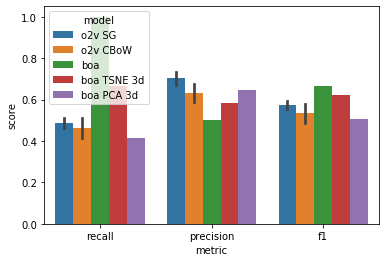

In [10]:
sns.barplot(data=df, hue='model', y = 'score', x='metric', ci="sd")
plt.savefig("object_task.png")

In [11]:
stats = {}
for metric in ["precision","recall","f1"]:
    mean = df[df['metric']==metric].groupby('model')['score'].mean()
    sd = df[df['metric']==metric].groupby('model')['score'].std()
    stats[metric] = pd.concat([mean, sd], axis=1, keys=['mean', 'std'])
stats = pd.concat([stats["precision"], stats["recall"], stats["f1"]], axis=1, keys=["precision","recall","f1"])
print(stats.to_markdown())
stats
print(stats.to_latex())

| model       |   ('precision', 'mean') |   ('precision', 'std') |   ('recall', 'mean') |   ('recall', 'std') |   ('f1', 'mean') |   ('f1', 'std') |
|:------------|------------------------:|-----------------------:|---------------------:|--------------------:|-----------------:|----------------:|
| boa         |                0.5      |            nan         |             1        |         nan         |         0.666667 |     nan         |
| boa PCA 3d  |                0.647887 |            nan         |             0.41629  |         nan         |         0.506887 |     nan         |
| boa TSNE 3d |                0.583333 |            nan         |             0.665158 |         nan         |         0.621564 |     nan         |
| o2v CBoW    |                0.63188  |              0.0468948 |             0.462443 |           0.0522228 |         0.533839 |       0.051284  |
| o2v SG      |                0.70328  |              0.0356406 |             0.485973 |           0.0287

In [30]:
type(o_embeddings)

torch.Tensor

In [9]:
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_1samp
import numpy

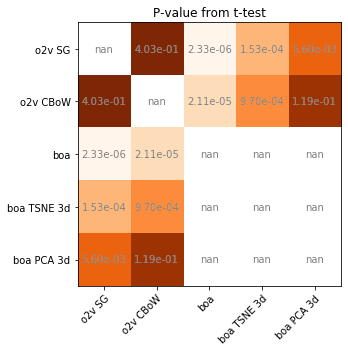

In [12]:
df_ = df[df['metric']=='recall']
models = ['o2v SG', 'o2v CBoW', 'boa', 'boa TSNE 3d', 'boa PCA 3d']
ps = np.ndarray((len(models), len(models),))
for i, first_model in enumerate(models):
    for j, second_model in enumerate(models):
        if i != j:
            first_df = df_[df_['model'] == first_model]['score']
            second_df = df_[df_['model'] == second_model]['score']
            if len(first_df) > 1:
                if len(second_df) > 1:
                    p = ttest_ind(first_df, second_df)[1]
                else:
                    p = ttest_1samp(first_df, second_df)[1]
            else:
                if len(second_df) > 1:
                    p = ttest_1samp(second_df, first_df)[1]
                else:
                    p = 'nan'
        else:
            p = 'nan'
        ps[i, j] = p


fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(np.log(ps), cmap="Oranges")#Dark2_r

# We want to show all ticks...
ax.set_xticks(np.arange(len(models)))
ax.set_yticks(np.arange(len(models)))
# ... and label them with the respective list entries
ax.set_xticklabels(models)
ax.set_yticklabels(models)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(models)):
    for j in range(len(models)):
        if ps[i, j] != np.float('nan'):
            text = ax.text(j, i, f"{ps[i, j]:.2e}",
                        ha="center", va="center", color="w")
            text = ax.text(j, i, f"{ps[i, j]:.2e}",
                        ha="center", va="center", color="black", alpha=.5)

ax.set_title(f"P-value from t-test")
fig.tight_layout()
plt.show()

In [7]:
df_

Unnamed: 0        model metric     score
2            2       o2v SG     f1  0.596306
5            5     o2v CBoW     f1  0.522427
8            8       o2v SG     f1  0.579634
11          11     o2v CBoW     f1  0.498688
14          14       o2v SG     f1  0.546479
17          17     o2v CBoW     f1  0.603093
20          20       o2v SG     f1  0.582418
23          23     o2v CBoW     f1  0.567775
26          26       o2v SG     f1  0.564103
29          29     o2v CBoW     f1  0.477212
32          32          boa     f1  0.666667
35          35  boa TSNE 3d     f1  0.621564
38          38   boa PCA 3d     f1  0.506887

In [14]:
import math
math.sqrt(0.05)

0.22360679774997896